<a href="https://colab.research.google.com/github/karrivinay54/Tuberculosis/blob/main/demo_V_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Unzip the file
!unzip -q Shenzhen.zip

replace Shenzhen/ann/CHNCXR_0001_0.png.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [6]:
# (If your folders are inside another folder, you might need to change the path,
# e.g., 'shenzhen_data/img', but let's try this first)

print("Counting images...")
!ls /content/Shenzhen/img| wc -l

print("\nCounting masks...")
!ls /content/Shenzhen/mask | wc -l

Counting images...
566

Counting masks...
566


In [10]:
#step 4
# We'll use the 'albumentations' library as it's very powerful
# for segmentation data augmentation, but let's start with OpenCV
# and TensorFlow first.

!pip install -q tensorflow opencv-python-headless

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2  # This is OpenCV
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [11]:
#step 5
# --- 1. Define constants ---
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3 # Our X-rays are likely grayscale, but we'll load as RGB for simplicity
IMAGE_DIR = '/content/Shenzhen/img'
MASK_DIR = '/content/Shenzhen/mask'

# --- 2. Get all file paths and sort them ---
# (Sorting is critical to ensure images match their masks)
image_files = sorted([os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR) if f.endswith('.png')])
mask_files = sorted([os.path.join(MASK_DIR, f) for f in os.listdir(MASK_DIR) if f.endswith('.png')])

# --- 3. Create lists to hold our data ---
# X_data will hold the images
# y_data will hold the masks
X_data = []
y_data = []

print(f"Loading {len(image_files)} images and masks...")

# --- 4. Define the loading function ---
def load_and_preprocess(image_path, mask_path):
    # Load Image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR) # Load as 3-channel (RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0  # Normalize to [0, 1]

    # Load Mask
    # We load the mask in grayscale (0)
    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = mask / 255.0  # Normalize to [0, 1]

    # We need to make the mask binary (0 or 1)
    # We'll threshold it: anything > 0.5 becomes 1, else 0
    mask = (mask > 0.5).astype(np.float32)

    # We need to add a channel dimension to the mask
    # Model output will be (256, 256, 1)
    mask = np.expand_dims(mask, axis=-1)

    return img, mask

# --- 5. Loop and load all data ---
for img_path, mask_path in zip(image_files, mask_files):
    img, mask = load_and_preprocess(img_path, mask_path)
    X_data.append(img)
    y_data.append(mask)

# --- 6. Convert lists to NumPy arrays ---
# This is the format the model needs
X = np.array(X_data, dtype=np.float32)
y = np.array(y_data, dtype=np.float32)

print("\nData loading complete!")
print(f"X (images) shape: {X.shape}")
print(f"y (masks) shape: {y.shape}")

Loading 566 images and masks...

Data loading complete!
X (images) shape: (566, 256, 256, 3)
y (masks) shape: (566, 256, 256, 1)


In [13]:
# We'll use 80% for training and 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training images: {X_train.shape[0]}")
print(f"Validation images: {X_val.shape[0]}")

Training images: 452
Validation images: 114


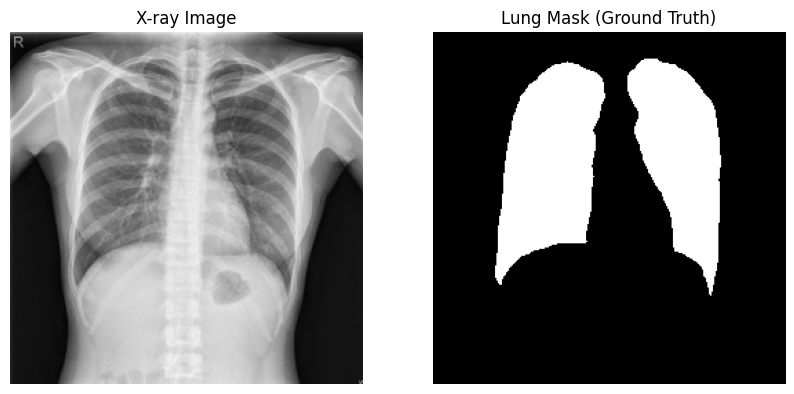

In [14]:
#step 7
# Let's check a random image from the training set
import random
ix = random.randint(0, len(X_train) - 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the image
ax[0].imshow(X_train[ix])
ax[0].set_title('X-ray Image')
ax[0].axis('off')

# Plot the mask
# We use .squeeze() to remove the extra (256, 256, 1) dimension for plotting
ax[1].imshow(y_train[ix].squeeze(), cmap='gray')
ax[1].set_title('Lung Mask (Ground Truth)')
ax[1].axis('off')

plt.show()

In [15]:
#step 8
# We'll use the 'tensorflow.keras.layers' we imported earlier
# (Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate)

def build_unet_model(input_shape):
    inputs = Input(input_shape)

    # --- Encoder (Contracting Path) ---

    # Block 1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Block 3
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Block 4
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # --- Decoder (Expansive Path) ---

    # Block 6 (Upsample + concatenate with c4)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4]) # This is the "skip connection"
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # Block 7 (Upsample + concatenate with c3)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Block 8 (Upsample + concatenate with c2)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    # Block 9 (Upsample + concatenate with c1)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # --- Output Layer ---
    # Final 1x1 convolution with a sigmoid activation
    # Sigmoid squishes the output to be between 0 and 1,
    # perfect for a binary mask (pixel is lung / pixel is not lung)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# --- Create the model ---
# Our input shape is (256, 256, 3)
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = build_unet_model(input_shape)

# Let's see a summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#step 9
# A custom metric for segmentation: Dice Coefficient
# It's a measure of overlap (IoU is similar)
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=[dice_coefficient])

In [17]:
#step 10
# --- Define training parameters ---
EPOCHS = 25
BATCH_SIZE = 16 # How many images to look at before updating weights

# --- Start training ---
# We store the training process in a 'history' object
# This lets us plot the learning curves later

print("Starting training...")
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val))

print("Training complete!")

Starting training...
Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - dice_coefficient: 0.2792 - loss: 0.5674 - val_dice_coefficient: 0.2775 - val_loss: 0.5311
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - dice_coefficient: 0.3597 - loss: 0.4454 - val_dice_coefficient: 0.3536 - val_loss: 0.4170
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - dice_coefficient: 0.4948 - loss: 0.3221 - val_dice_coefficient: 0.3006 - val_loss: 0.4779
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - dice_coefficient: 0.6199 - loss: 0.2417 - val_dice_coefficient: 0.4366 - val_loss: 0.4318
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - dice_coefficient: 0.8316 - loss: 0.1488 - val_dice_coefficient: 0.5592 - val_loss: 0.3314
Epoch 6/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - dice_coefficient: 0.8719 - loss: 0.1176 - val_dice_coefficient: 0.5890 - val_loss: 0.3216
Epoch 7/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - dice_coefficient: 0.8806 - loss: 0.1113 - val_dice_coefficient:

In [18]:
#model_v2
#alternate steps
#step 1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [24]:
#step 2
# --- Define the augmentations ---
# We will apply the *same* augmentation to both the image and the mask
# We must use the same 'seed' for both generators to ensure this.

# Keras's ImageDataGenerator wants values in the [0, 255] range for augmentation
# So we will NOT normalize with '/ 255.0' here. We'll use the 'rescale' arg.
X_train_aug = X_train * 255.0
y_train_aug = y_train * 255.0 # Keras aug needs masks to be 0 or 255
X_val_norm = X_val * 255.0
y_val_norm = y_val * 255.0


train_gen_args = dict(
    rescale=1./255,          # Normalize to [0, 1]
    rotation_range=10,       # Randomly rotate up to 10 degrees
    width_shift_range=0.1,   # Shift image horizontally by 10%
    height_shift_range=0.1,  # Shift image vertically by 10%
    zoom_range=0.1,          # Zoom in by 10%
    horizontal_flip=True,    # Randomly flip horizontally
    fill_mode='nearest'
)

val_gen_args = dict(
    rescale=1./255           # For validation, just normalize
)

# --- Create the Generators ---
# Note the use of the *same seed* to ensure X_train and y_train are
# augmented in the exact same way.
seed = 1

image_datagen = ImageDataGenerator(**train_gen_args)
mask_datagen = ImageDataGenerator(**train_gen_args)

val_image_datagen = ImageDataGenerator(**val_gen_args)
val_mask_datagen = ImageDataGenerator(**val_gen_args)

# --- Create the data "flows" ---
# This is what we'll feed to the model
batch_size = 16 # We can use the same batch size

train_image_generator = image_datagen.flow(
    X_train_aug,
    batch_size=batch_size,
    seed=seed
)

train_mask_generator = mask_datagen.flow(
    y_train_aug,
    batch_size=batch_size,
    seed=seed
)

val_image_generator = val_image_datagen.flow(
    X_val_norm,
    batch_size=batch_size,
    seed=seed
)

val_mask_generator = val_mask_datagen.flow(
    y_val_norm,
    batch_size=batch_size,
    seed=seed
)

# This final generator zips them together
# We create a wrapper function that Keras understands

def generator_wrapper(img_gen, mask_gen):
    while True:
        yield(next(img_gen), next(mask_gen))

train_generator = generator_wrapper(train_image_generator, train_mask_generator)
val_generator = generator_wrapper(val_image_generator, val_mask_generator)

print("Data generators created successfully!")

Data generators created successfully!


In [25]:
#step 3
# --- Re-build ---
# (This code is from Step 8)
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model_v2 = build_unet_model(input_shape)

# --- Re-compile ---
# (This code is from Step 9)
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

model_v2.compile(optimizer=Adam(learning_rate=1e-4),
                 loss='binary_crossentropy',
                 metrics=[dice_coefficient])

print("Model V2 created and compiled.")

Model V2 created and compiled.


In [26]:
#step 4
# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# We can also add an EarlyStopping callback
# If val_loss doesn't improve for 15 epochs, it will just stop training
# This saves us time.
# from tensorflow.keras.callbacks import EarlyStopping
# early_stopper = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# For now, let's just use the LR scheduler.
callbacks_list = [lr_scheduler]

In [27]:
#step 5
# --- Define training parameters ---
EPOCHS = 50 # Let's train for longer
# BATCH_SIZE is already 16

# Calculate steps
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size


print("Starting enhanced training...")
history_v2 = model_v2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

print("Enhanced training complete!")

Starting enhanced training...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 432ms/step - dice_coefficient: 0.3444 - loss: 0.7483 - val_dice_coefficient: 0.3150 - val_loss: 0.6284 - learning_rate: 1.0000e-04
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 366ms/step - dice_coefficient: 0.3089 - loss: 0.6183 - val_dice_coefficient: 0.2931 - val_loss: 0.5535 - learning_rate: 1.0000e-04
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 779ms/step - dice_coefficient: 0.3311 - loss: 0.4997 - val_dice_coefficient: 0.3442 - val_loss: 0.4841 - learning_rate: 1.0000e-04
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - dice_coefficient: 0.4169 - loss: 0.4119 - val_dice_coefficient: 0.3819 - val_loss: 0.4634 - learning_rate: 1.0000e-04
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - dice_coefficient: 0.4669 - loss: 0.3646 - val_dice_coefficient: 0.4682 - val_loss: 0.3607 - learning_rate: 1.0000e-04
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 373ms/step - dice_coefficient: 0.6945 - loss: 0.2689 - val_dice_c

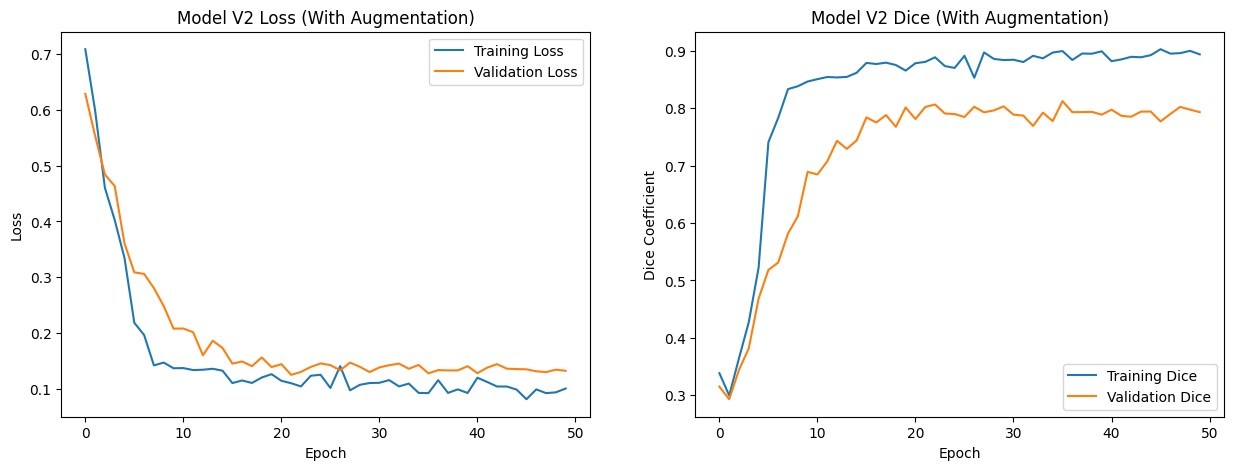

In [28]:
#step 11
# Plot the learning curves for the new model
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax[0].plot(history_v2.history['loss'], label='Training Loss')
ax[0].plot(history_v2.history['val_loss'], label='Validation Loss')
ax[0].set_title('Model V2 Loss (With Augmentation)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot Dice Coefficient
ax[1].plot(history_v2.history['dice_coefficient'], label='Training Dice')
ax[1].plot(history_v2.history['val_dice_coefficient'], label='Validation Dice')
ax[1].set_title('Model V2 Dice (With Augmentation)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Dice Coefficient')
ax[1].legend()

plt.show()

In [29]:
#step 12
print("Evaluating model V2 on validation set...")
# We use the 'val_generator' to evaluate
scores_v2 = model_v2.evaluate(val_generator, steps=validation_steps, verbose=1)

print(f"\nValidation Loss: {scores_v2[0]:.4f}")
print(f"Validation Dice Coefficient: {scores_v2[1]:.4f}")

Evaluating model V2 on validation set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - dice_coefficient: 0.8028 - loss: 0.1373

Validation Loss: 0.1356
Validation Dice Coefficient: 0.8026


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Displaying predictions from Model V2...


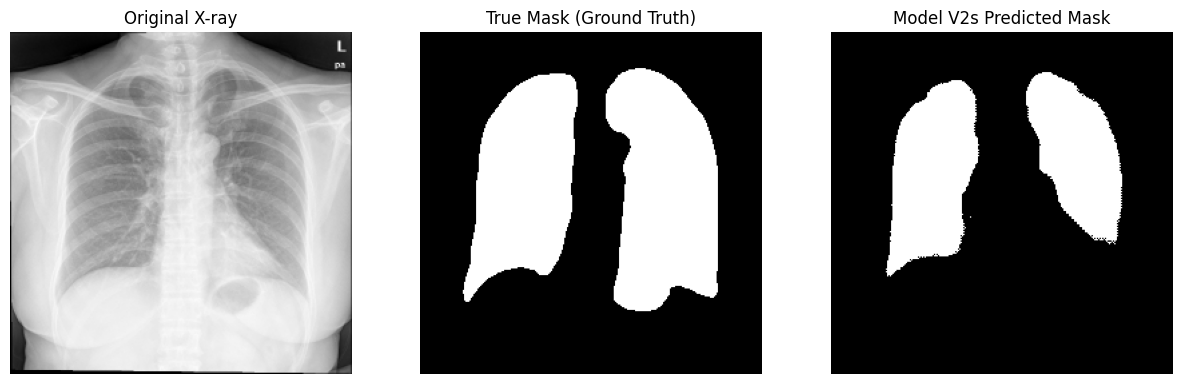

In [33]:
# Get predictions on the validation set
# We have to predict on the *normalized* validation data, not the generator
preds_val_v2 = model_v2.predict(X_val)

# Threshold them just like before
preds_val_t_v2 = (preds_val_v2 > 0.5).astype(np.uint8)

# --- Now let's plot a few random examples ---

print("Displaying predictions from Model V2...")
ix = random.randint(0, len(X_val) - 1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 1. Plot the Original Image
ax[0].imshow(X_val[ix])
ax[0].set_title('Original X-ray')
ax[0].axis('off')

# 2. Plot the True Mask (from our dataset)
ax[1].imshow(y_val[ix].squeeze(), cmap='gray')
ax[1].set_title('True Mask (Ground Truth)')
ax[1].axis('off')

# 3. Plot the Predicted Mask (from our new model)
ax[2].imshow(preds_val_t_v2[ix].squeeze(), cmap='gray')
ax[2].set_title('Model V2''s Predicted Mask')
ax[2].axis('off')

plt.show()

In [34]:
#model_v3
# Import the BCE loss
from tensorflow.keras.losses import BinaryCrossentropy

# We need to redefine our Dice functions to work purely in TensorFlow
# for the loss function
def dice_coeff(y_true, y_pred, smooth=1e-6):
    # Flatten the tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

# Let's create our combined loss
bce_loss = BinaryCrossentropy()

def combined_loss(y_true, y_pred):
    # We give equal weight to both losses
    return bce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)

print("Dice Loss and Combined Loss are defined.")

Dice Loss and Combined Loss are defined.


In [35]:
# --- Re-build ---
# (This code is from Step 8)
print("Building Model V3...")
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model_v3 = build_unet_model(input_shape)

# --- Re-compile with new loss ---
# We still use Adam
# We still use dice_coeff as a METRIC to watch
# But we use combined_loss as the LOSS to learn from
print("Compiling Model V3...")
model_v3.compile(optimizer=Adam(learning_rate=1e-4),
                 loss=combined_loss,
                 metrics=[dice_coeff]) # We'll use our new TF-based dice_coeff

print("Model V3 created and compiled.")

Building Model V3...
Compiling Model V3...
Model V3 created and compiled.


In [36]:
# --- Use the same generators and callbacks from Step 4 (V2) ---
# train_generator
# val_generator
# callbacks_list (our ReduceLROnPlateau)
# steps_per_epoch
# validation_steps

EPOCHS = 50 # 50 epochs was a good test

print("Starting training for Model V3 (with Combined Loss)...")
history_v3 = model_v3.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list  # This is our ReduceLROnPlateau
)

print("Training for Model V3 complete!")

Starting training for Model V3 (with Combined Loss)...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 877ms/step - dice_coeff: 0.3232 - loss: 1.3368 - val_dice_coeff: 0.3056 - val_loss: 1.2883 - learning_rate: 1.0000e-04
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - dice_coeff: 0.3246 - loss: 1.2277 - val_dice_coeff: 0.3756 - val_loss: 1.1355 - learning_rate: 1.0000e-04
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - dice_coeff: 0.4664 - loss: 0.9396 - val_dice_coeff: 0.4384 - val_loss: 0.9631 - learning_rate: 1.0000e-04
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - dice_coeff: 0.6722 - loss: 0.6331 - val_dice_coeff: 0.6452 - val_loss: 0.6162 - learning_rate: 1.0000e-04
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - dice_coeff: 0.7999 - loss: 0.4530 - val_dice_coeff: 0.6735 - val_loss: 0.5634 - learning_rate: 1.0000e-04
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 375ms/step - dice_coeff: 0.8361 - loss: 0.3710 - val_dice_coeff: 0.6993 - val_loss: 0.5310 - learning_

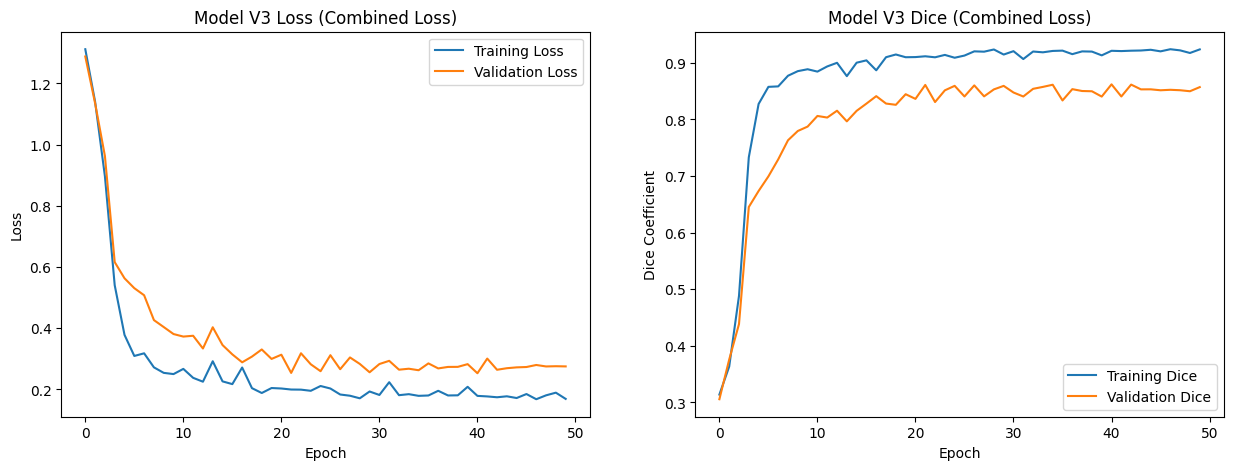

In [37]:
# Plot the learning curves for the new model
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax[0].plot(history_v3.history['loss'], label='Training Loss')
ax[0].plot(history_v3.history['val_loss'], label='Validation Loss')
ax[0].set_title('Model V3 Loss (Combined Loss)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot Dice Coefficient
ax[1].plot(history_v3.history['dice_coeff'], label='Training Dice')
ax[1].plot(history_v3.history['val_dice_coeff'], label='Validation Dice')
ax[1].set_title('Model V3 Dice (Combined Loss)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Dice Coefficient')
ax[1].legend()

plt.show()

In [38]:
print("Evaluating model V3 on validation set...")
# We use the 'val_generator' to evaluate
scores_v3 = model_v3.evaluate(val_generator, steps=validation_steps, verbose=1)

print(f"\nFinal Validation Loss: {scores_v3[0]:.4f}")
print(f"Final Validation Dice Coefficient: {scores_v3[1]:.4f}")

Evaluating model V3 on validation set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - dice_coeff: 0.8566 - loss: 0.2647

Final Validation Loss: 0.2577
Final Validation Dice Coefficient: 0.8611


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step
Displaying predictions from Model V3 (Combined Loss)...


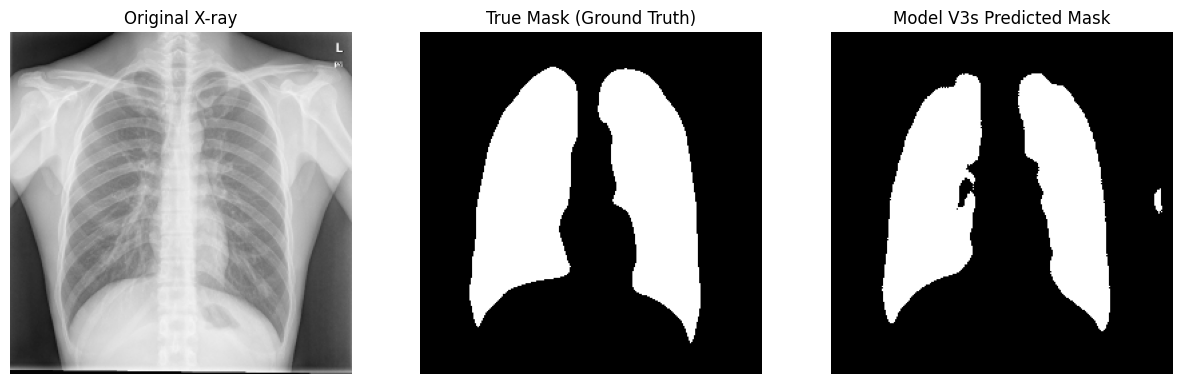

In [39]:
# Get predictions on the validation set
preds_val_v3 = model_v3.predict(X_val)

# Threshold them just like before
preds_val_t_v3 = (preds_val_v3 > 0.5).astype(np.uint8)

# --- Now let's plot a few random examples ---

print("Displaying predictions from Model V3 (Combined Loss)...")
ix = random.randint(0, len(X_val) - 1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 1. Plot the Original Image
ax[0].imshow(X_val[ix])
ax[0].set_title('Original X-ray')
ax[0].axis('off')

# 2. Plot the True Mask (from our dataset)
ax[1].imshow(y_val[ix].squeeze(), cmap='gray')
ax[1].set_title('True Mask (Ground Truth)')
ax[1].axis('off')

# 3. Plot the Predicted Mask (from our new model)
ax[2].imshow(preds_val_t_v3[ix].squeeze(), cmap='gray')
ax[2].set_title('Model V3''s Predicted Mask')
ax[2].axis('off')

plt.show()

In [40]:
#model_v4
from tensorflow.keras.applications import MobileNetV2

print("Loading pre-trained MobileNetV2 encoder...")

# Load the base model
base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

# We want to fine-tune the encoder, so we'll set it as trainable
base_model.trainable = True

print("Encoder loaded.")

Loading pre-trained MobileNetV2 encoder...


/tmp/ipython-input-2030198698.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Encoder loaded.


In [41]:
def build_mobilenet_unet(base_model, input_shape):
    # --- 1. Get the Encoder Skip Connections ---
    # These are the specific layer names from MobileNetV2
    # that give us outputs at different scales (like our old U-Net)
    skip_layer_names = [
        'block_1_expand_relu',   # 128x128
        'block_3_expand_relu',   # 64x64
        'block_6_expand_relu',   # 32x32
        'block_13_expand_relu',  # 16x16
    ]

    # Get the actual layer outputs
    skip_outputs = [base_model.get_layer(name).output for name in skip_layer_names]

    # Get the main input and the final "bottleneck" output from the encoder
    inputs = base_model.input
    bottleneck = base_model.output # This is 8x8

    # --- 2. Create the Decoder ---
    # We build our decoder "up" from the bottleneck, just like before

    # Upsample from 8x8 to 16x16
    d1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    d1 = concatenate([d1, skip_outputs[3]]) # Connect to 16x16 skip (block_13)
    c1 = Conv2D(512, (3, 3), activation='relu', padding='same')(d1)

    # Upsample from 16x16 to 32x32
    d2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c1)
    d2 = concatenate([d2, skip_outputs[2]]) # Connect to 32x32 skip (block_6)
    c2 = Conv2D(256, (3, 3), activation='relu', padding='same')(d2)

    # Upsample from 32x32 to 64x64
    d3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c2)
    d3 = concatenate([d3, skip_outputs[1]]) # Connect to 64x64 skip (block_3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(d3)

    # Upsample from 64x64 to 128x128
    d4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    d4 = concatenate([d4, skip_outputs[0]]) # Connect to 128x128 skip (block_1)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(d4)

    # Upsample from 128x128 to 256x256
    d5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(d5)

    # --- 3. Output Layer ---
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# --- Create Model V4 ---
print("Building Model V4 (MobileNetV2-UNet)...")
model_v4 = build_mobilenet_unet(base_model, input_shape)

print("Model V4 built.")

Building Model V4 (MobileNetV2-UNet)...
Model V4 built.


In [42]:
# --- Compile with our best settings ---
# We'll use a slower learning rate for fine-tuning
print("Compiling Model V4...")
model_v4.compile(
    optimizer=Adam(learning_rate=1e-5), # Slower LR!
    loss=combined_loss,
    metrics=[dice_coeff]
)

# We also need a new LR scheduler for this new training run
lr_scheduler_v4 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-8, # Even smaller min LR
    verbose=1
)
callbacks_list_v4 = [lr_scheduler_v4]

print("Model V4 compiled.")
model_v4.summary() # Let's see the new architecture

Compiling Model V4...
Model V4 compiled.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 12,038,177 (45.92 MB)

 Trainable params: 12,004,065 (45.79 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [43]:
EPOCHS = 50

print("Starting training for Model V4 (MobileNetV2-UNet)...")
history_v4 = model_v4.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list_v4
)

print("Training for Model V4 complete!")

Starting training for Model V4 (MobileNetV2-UNet)...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - dice_coeff: 0.3916 - loss: 1.5706 - val_dice_coeff: 0.3369 - val_loss: 1.4577 - learning_rate: 1.0000e-05
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 364ms/step - dice_coeff: 0.3598 - loss: 1.4134 - val_dice_coeff: 0.3186 - val_loss: 1.3630 - learning_rate: 1.0000e-05
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step - dice_coeff: 0.3469 - loss: 1.3115 - val_dice_coeff: 0.2974 - val_loss: 1.2959 - learning_rate: 1.0000e-05
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 389ms/step - dice_coeff: 0.3720 - loss: 1.1670 - val_dice_coeff: 0.2809 - val_loss: 1.2282 - learning_rate: 1.0000e-05
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 373ms/step - dice_coeff: 0.4976 - loss: 0.8797 - val_dice_coeff: 0.2174 - val_loss: 1.4047 - learning_rate: 1.0000e-05
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 375ms/step - dice_coeff: 0.6639 - loss: 0.6130 - val_dice_coeff: 0.1333 - val_loss: 1.9140 - learning_

In [44]:
#model_5
from tensorflow.keras.applications import MobileNetV2

print("Loading pre-trained MobileNetV2 encoder for V5...")
# Load a new base model
base_model_v5 = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

# --- THIS IS THE CRUCIAL STEP ---
# Freeze the pre-trained weights
base_model_v5.trainable = False
# ---------------------------------

print("Building Model V5 with FROZEN encoder...")
# We can reuse our 'build_mobilenet_unet' function
model_v5 = build_mobilenet_unet(base_model_v5, input_shape)
print("Model V5 built.")

Loading pre-trained MobileNetV2 encoder for V5...


/tmp/ipython-input-2615128812.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_v5 = MobileNetV2(


Building Model V5 with FROZEN encoder...
Model V5 built.


In [45]:
# --- Compile for Stage 1 ---
print("Compiling Model V5 for Stage 1 (Warm-up)...")
model_v5.compile(
    optimizer=Adam(learning_rate=1e-4), # A standard LR
    loss=combined_loss,
    metrics=[dice_coeff]
)

# We'll use a simple LR scheduler for this stage
lr_scheduler_v5_stage1 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Drop LR more aggressively if it stalls
    patience=3,
    verbose=1,
    min_lr=1e-6
)

print("Model V5 compiled.")
model_v5.summary() # Look at the "Trainable params" - it should be much smaller!

Compiling Model V5 for Stage 1 (Warm-up)...
Model V5 compiled.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 12,038,177 (45.92 MB)

 Trainable params: 9,780,193 (37.31 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [46]:
EPOCHS_STAGE_1 = 20

print("Starting Stage 1 training (Decoder Warm-up)...")
history_v5_stage1 = model_v5.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS_STAGE_1,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler_v5_stage1]
)

print("Stage 1 (Warm-up) complete!")

Starting Stage 1 training (Decoder Warm-up)...
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - dice_coeff: 0.3375 - loss: 1.2624 - val_dice_coeff: 0.7091 - val_loss: 0.5724 - learning_rate: 1.0000e-04
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step - dice_coeff: 0.7590 - loss: 0.4838 - val_dice_coeff: 0.8676 - val_loss: 0.2658 - learning_rate: 1.0000e-04
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 357ms/step - dice_coeff: 0.8566 - loss: 0.3609 - val_dice_coeff: 0.9146 - val_loss: 0.1847 - learning_rate: 1.0000e-04
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step - dice_coeff: 0.8230 - loss: 0.4294 - val_dice_coeff: 0.9203 - val_loss: 0.1652 - learning_rate: 1.0000e-04
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - dice_coeff: 0.8813 - loss: 0.3162 - val_dice_coeff: 0.9237 - val_loss: 0.1601 - learning_rate: 1.0000e-04
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 361ms/step - dice_coeff: 0.8567 - loss: 0.4123 - val_dice_coeff: 0.9295 - val_loss: 0.1556 - learning_rate: 1.

In [47]:
print("Unfreezing the encoder (MobileNetV2) for fine-tuning...")

# This is the same base model from Stage 1
base_model_v5.trainable = True

print("Encoder is now unfrozen.")

Unfreezing the encoder (MobileNetV2) for fine-tuning...
Encoder is now unfrozen.


In [48]:
# --- Compile for Stage 2 (Fine-Tuning) ---
print("Re-compiling Model V5 for Stage 2...")

# We'll use a tiny learning rate to "nudge" the big encoder
# 1e-6 is a good, safe starting point for fine-tuning
model_v5.compile(
    optimizer=Adam(learning_rate=1e-6), # TINY learning rate
    loss=combined_loss,
    metrics=[dice_coeff]
)

# We'll use a new scheduler for this slow process
lr_scheduler_v5_stage2 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,     # Cut LR in half
    patience=4,     # Be patient
    verbose=1,
    min_lr=1e-8     # Allow it to get extremely small
)

print("Model V5 re-compiled and ready for fine-tuning.")
model_v5.summary() # Look at the "Trainable params" now. It should be huge!

Re-compiling Model V5 for Stage 2...
Model V5 re-compiled and ready for fine-tuning.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 12,038,177 (45.92 MB)

 Trainable params: 12,004,065 (45.79 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [49]:
EPOCHS_STAGE_2 = 30
# We're continuing from the 20 epochs we already ran
initial_epoch = history_v5_stage1.epoch[-1] + 1 # This will be 20

print(f"Starting Stage 2 training (Fine-Tuning) for {EPOCHS_STAGE_2} more epochs...")

# We fit the SAME model_v5. We are continuing its training.
history_v5_stage2 = model_v5.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=initial_epoch + EPOCHS_STAGE_2, # Train from epoch 20 to 50
    initial_epoch=initial_epoch,           # Tell it where we left off
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler_v5_stage2]
)

print("Stage 2 (Fine-Tuning) complete!")

Starting Stage 2 training (Fine-Tuning) for 30 more epochs...
Epoch 21/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - dice_coeff: 0.8790 - loss: 0.2582 - val_dice_coeff: 0.9306 - val_loss: 0.1387 - learning_rate: 1.0000e-06
Epoch 22/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 358ms/step - dice_coeff: 0.8709 - loss: 0.2984 - val_dice_coeff: 0.9269 - val_loss: 0.1427 - learning_rate: 1.0000e-06
Epoch 23/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 396ms/step - dice_coeff: 0.8199 - loss: 0.4943 - val_dice_coeff: 0.9318 - val_loss: 0.1463 - learning_rate: 1.0000e-06
Epoch 24/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 385ms/step - dice_coeff: 0.8344 - loss: 0.4530 - val_dice_coeff: 0.9301 - val_loss: 0.1404 - learning_rate: 1.0000e-06
Epoch 25/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - dice_coeff: 0.8252 - loss: 0.4743
Epoch 25: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 360ms/step - dice_coeff: 0.8270 - loss: 0.4681 - val_dice_coeff: 0.9291 - val_loss: 0.1506 - le

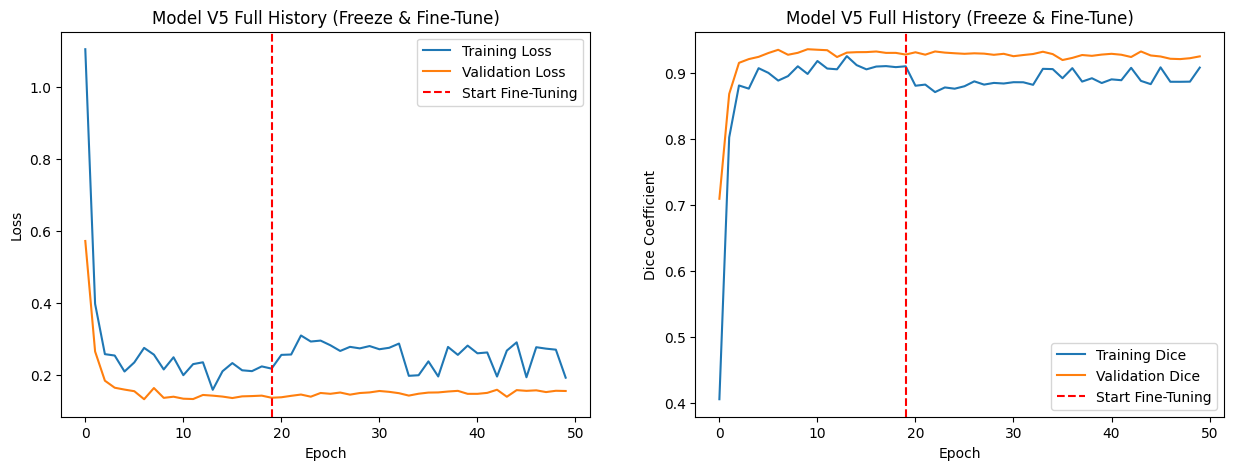

In [50]:
# Combine the two history dictionaries
full_history = {}
for key in history_v5_stage1.history.keys():
    full_history[key] = history_v5_stage1.history[key] + history_v5_stage2.history[key]

# Plot the learning curves for the new model
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax[0].plot(full_history['loss'], label='Training Loss')
ax[0].plot(full_history['val_loss'], label='Validation Loss')
ax[0].set_title('Model V5 Full History (Freeze & Fine-Tune)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
# Add a line to show where Stage 2 started
ax[0].axvline(x=19, color='red', linestyle='--', label='Start Fine-Tuning')
ax[0].legend()

# Plot Dice Coefficient
ax[1].plot(full_history['dice_coeff'], label='Training Dice')
ax[1].plot(full_history['val_dice_coeff'], label='Validation Dice')
ax[1].set_title('Model V5 Full History (Freeze & Fine-Tune)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Dice Coefficient')
# Add a line to show where Stage 2 started
ax[1].axvline(x=19, color='red', linestyle='--', label='Start Fine-Tuning')
ax[1].legend()

plt.show()

In [51]:
print("Evaluating final Model V5 (Epoch 50) on validation set...")
# We use the 'val_generator' to evaluate
scores_v5 = model_v5.evaluate(val_generator, steps=validation_steps, verbose=1)

print(f"\nFinal Validation Loss: {scores_v5[0]:.4f}")
print(f"Final Validation Dice Coefficient: {scores_v5[1]:.4f}")

Evaluating final Model V5 (Epoch 50) on validation set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - dice_coeff: 0.9250 - loss: 0.1562

Final Validation Loss: 0.1532
Final Validation Dice Coefficient: 0.9253


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Displaying predictions from Model V5 (MobileNetV2-UNet)...


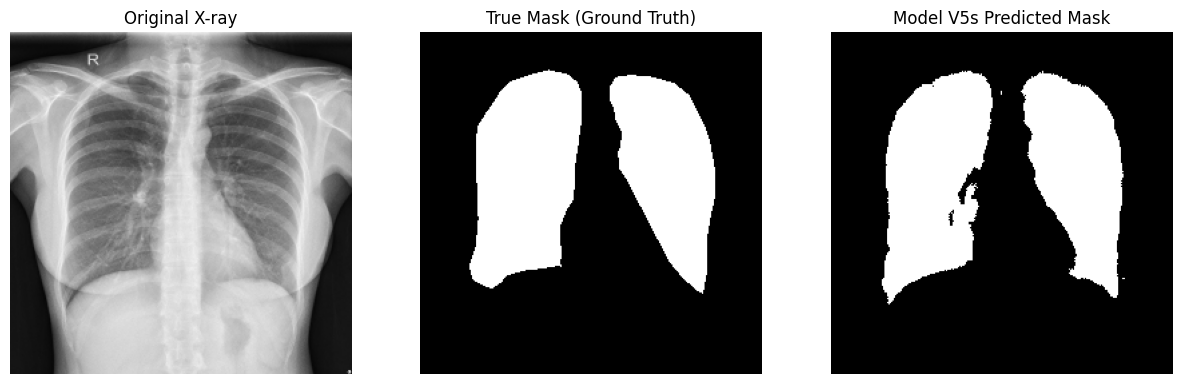

In [55]:
# Get predictions on the validation set
preds_val_v5 = model_v5.predict(X_val)

# Threshold them
preds_val_t_v5 = (preds_val_v5 > 0.5).astype(np.uint8)

# --- Now let's plot a few random examples ---
print("Displaying predictions from Model V5 (MobileNetV2-UNet)...")
ix = random.randint(0, len(X_val) - 1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 1. Plot the Original Image
ax[0].imshow(X_val[ix])
ax[0].set_title('Original X-ray')
ax[0].axis('off')

# 2. Plot the True Mask (from our dataset)
ax[1].imshow(y_val[ix].squeeze(), cmap='gray')
ax[1].set_title('True Mask (Ground Truth)')
ax[1].axis('off')

# 3. Plot the Predicted Mask (from our new model)
ax[2].imshow(preds_val_t_v5[ix].squeeze(), cmap='gray')
ax[2].set_title('Model V5''s Predicted Mask')
ax[2].axis('off')

plt.show()

In [56]:
import cv2 # We imported this way back in Step 4

def clean_mask(mask, num_contours_to_keep=2):
    """
    Cleans a binary mask by keeping only the N largest contours.

    Args:
    mask (np.array): A 2D binary mask (256, 256) of type uint8.
    num_contours_to_keep (int): The number of largest contours to keep.

    Returns:
    np.array: A cleaned 2D binary mask.
    """

    # Find all contours in the mask
    # cv2.RETR_EXTERNAL just gets the outer-most contours
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        # If no contours were found, return an empty mask
        return np.zeros_like(mask)

    # Sort the contours by area (largest first)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Get the top N contours
    contours_to_keep = sorted_contours[:num_contours_to_keep]

    # Create a new, blank mask
    new_mask = np.zeros_like(mask)

    # Draw *only* the contours we want to keep onto the blank mask
    # -1 fills the contour, (255) is the color (white)
    cv2.drawContours(new_mask, contours_to_keep, -1, (255), thickness=cv2.FILLED)

    # Our function outputs 0s and 255s, so we'll normalize it back to 0s and 1s
    new_mask = (new_mask / 255.0).astype(np.float32)

    return new_mask

print("clean_mask() function defined.")

clean_mask() function defined.


In [57]:
# We already have our 92.5% predictions in 'preds_val_t_v5'
# This is a list of (114, 256, 256, 1) masks.
# We need to squeeze them to (256, 256) for OpenCV.

print(f"Applying post-processing to {len(preds_val_t_v5)} masks...")

# Create a new list to hold our cleaned masks
preds_val_cleaned = []

for pred_mask in preds_val_t_v5:
    # Squeeze from (256, 256, 1) to (256, 256)
    # and make sure it's the right type (uint8)
    mask_2d = (pred_mask.squeeze()).astype(np.uint8)

    # Run our new cleanup function
    cleaned = clean_mask(mask_2d)

    # Add the channel dimension back on for consistency
    cleaned = np.expand_dims(cleaned, axis=-1)

    preds_val_cleaned.append(cleaned)

# Convert our list back to a big NumPy array
preds_val_cleaned = np.array(preds_val_cleaned)

print("Masks cleaned!")
print(f"Shape of cleaned masks: {preds_val_cleaned.shape}")

Applying post-processing to 114 masks...
Masks cleaned!
Shape of cleaned masks: (114, 256, 256, 1)


Displaying Post-Processing Results...


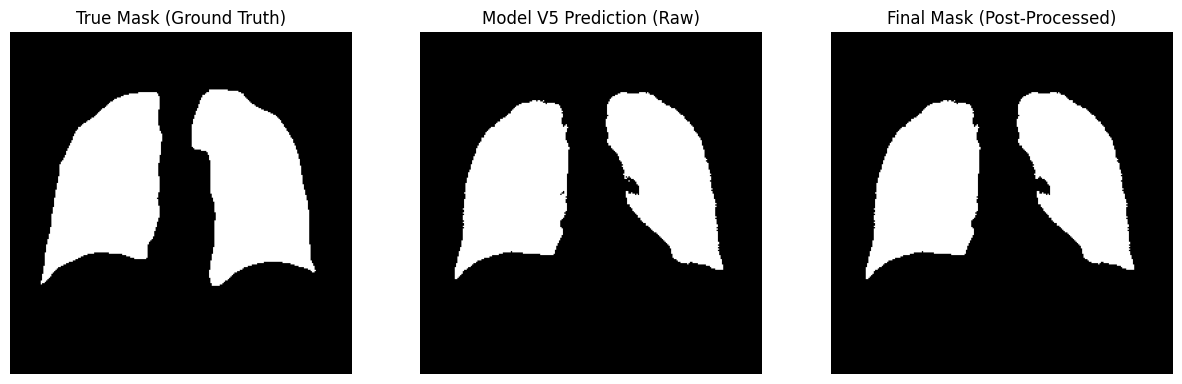

In [59]:
print("Displaying Post-Processing Results...")
ix = random.randint(0, len(X_val) - 1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 1. Plot the True Mask (The "Answer")
ax[0].imshow(y_val[ix].squeeze(), cmap='gray')
ax[0].set_title('True Mask (Ground Truth)')
ax[0].axis('off')

# 2. Plot the Model's Raw Prediction
ax[1].imshow(preds_val_t_v5[ix].squeeze(), cmap='gray')
ax[1].set_title('Model V5 Prediction (Raw)')
ax[1].axis('off')

# 3. Plot the Cleaned Mask
ax[2].imshow(preds_val_cleaned[ix].squeeze(), cmap='gray')
ax[2].set_title('Final Mask (Post-Processed)')
ax[2].axis('off')

plt.show()

In [60]:
# We'll use our TensorFlow 'dice_coeff' function
# We need to make sure our arrays are tf.float32
true_masks = tf.cast(y_val, tf.float32)
cleaned_preds = tf.cast(preds_val_cleaned, tf.float32)

final_dice_score = dice_coeff(true_masks, cleaned_preds)

print(f"Model V5 (Raw) Dice Score: {scores_v5[1]:.5f} (92.53%)")
print(f"Model V5 (Cleaned) Dice Score: {final_dice_score:.5f}")

Model V5 (Raw) Dice Score: 0.92528 (92.53%)
Model V5 (Cleaned) Dice Score: 0.94650


In [61]:
import numpy as np

print("Starting Stage 4: Threshold Optimization...")
print("This will test thresholds from 0.3 to 0.75")
print("---------------------------------------------")

# 1. Define the thresholds to check
# We use np.arange(start, stop, step)
thresholds = np.arange(0.3, 0.8, 0.05)

# 2. Get our raw predictions and true masks (as float32)
# (preds_val_v5 is from model_v5.predict())
# (y_val is our validation ground truth)
true_masks_tf = tf.cast(y_val, tf.float32)

# 3. Keep track of the best score
best_score = -1.0
best_threshold = -1.0

# 4. Loop through each threshold
for thresh in thresholds:
    # A. Apply the new threshold
    # Create binary masks (0 or 1) based on the current threshold
    preds_binary = (preds_val_v5 > thresh).astype(np.uint8)

    # B. Clean these new binary masks (apply our 'keep top 2' logic)
    cleaned_list_loop = []
    for pred_mask in preds_binary:
        # Squeeze from (256, 256, 1) to (256, 256)
        mask_2d = pred_mask.squeeze()

        # Run our cleanup function (which returns a float32 mask)
        cleaned = clean_mask(mask_2d)

        # Add the channel dimension back
        cleaned_list_loop.append(np.expand_dims(cleaned, axis=-1))

    preds_cleaned_loop = np.array(cleaned_list_loop)

    # C. Calculate the Dice score for these cleaned masks
    preds_cleaned_tf = tf.cast(preds_cleaned_loop, tf.float32)
    score = dice_coeff(true_masks_tf, preds_cleaned_tf).numpy() # .numpy() to get the value

    print(f"Threshold: {thresh:.2f}  ->  Dice Score: {score:.5f}")

    # D. Check if this is the new best
    if score > best_score:
        best_score = score
        best_threshold = thresh

print("---------------------------------------------")
print(f"Optimization Complete!")
print(f"\nOur old score (at 0.5 thresh): 0.94650")
print(f"The NEW BEST score is: {best_score:.5f}")
print(f"This was achieved with a threshold of: {best_threshold:.2f}")

Starting Stage 4: Threshold Optimization...
This will test thresholds from 0.3 to 0.75
---------------------------------------------
Threshold: 0.30  ->  Dice Score: 0.94779
Threshold: 0.35  ->  Dice Score: 0.94790
Threshold: 0.40  ->  Dice Score: 0.94773
Threshold: 0.45  ->  Dice Score: 0.94729
Threshold: 0.50  ->  Dice Score: 0.94650
Threshold: 0.55  ->  Dice Score: 0.94548
Threshold: 0.60  ->  Dice Score: 0.94419
Threshold: 0.65  ->  Dice Score: 0.94249
Threshold: 0.70  ->  Dice Score: 0.94039
Threshold: 0.75  ->  Dice Score: 0.93738
---------------------------------------------
Optimization Complete!

Our old score (at 0.5 thresh): 0.94650
The NEW BEST score is: 0.94790
This was achieved with a threshold of: 0.35


In [62]:
def clean_mask_v2(mask, num_contours_to_keep=2):
    """
    Cleans a binary mask by first filling in small holes (closing)
    and then keeping only the N largest contours.

    Args:
    mask (np.array): A 2D binary mask (256, 256) of type uint8.
    num_contours_to_keep (int): The number of largest contours to keep.

    Returns:
    np.array: A cleaned 2D binary mask (float32).
    """

    # --- NEW STEP: MORPHOLOGICAL CLOSING ---
    # Create a 'kernel' (a small 5x5 square)
    kernel = np.ones((5, 5), np.uint8)
    # 'Close' the mask: fills in small black holes inside white objects
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # ----------------------------------------

    # Find all contours in the *closed* mask
    contours, hierarchy = cv2.findContours(mask_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return np.zeros_like(mask, dtype=np.float32)

    # Sort the contours by area (largest first)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Get the top N contours
    contours_to_keep = sorted_contours[:num_contours_to_keep]

    # Create a new, blank mask
    new_mask = np.zeros_like(mask)

    # Draw *only* the contours we want to keep
    cv2.drawContours(new_mask, contours_to_keep, -1, (255), thickness=cv2.FILLED)

    # Normalize back to 0s and 1s (as float32)
    new_mask = (new_mask / 255.0).astype(np.float32)

    return new_mask

print("clean_mask_v2() (with hole-filling) defined.")

clean_mask_v2() (with hole-filling) defined.


In [63]:
print("Starting Final Test (Stage 5)...")

# 1. Get our best threshold
best_thresh = 0.35

# 2. Get our raw predictions and true masks
true_masks_tf = tf.cast(y_val, tf.float32)
# (preds_val_v5 is from model_v5.predict())

# 3. Apply threshold and use the NEW clean_mask_v2
preds_binary = (preds_val_v5 > best_thresh).astype(np.uint8)
cleaned_list_final = []

for pred_mask in preds_binary:
    mask_2d = pred_mask.squeeze()

    # Use the new v2 function
    cleaned = clean_mask_v2(mask_2d)

    cleaned_list_final.append(np.expand_dims(cleaned, axis=-1))

preds_cleaned_final = np.array(cleaned_list_final)

# 4. Calculate the Final Dice Score
preds_cleaned_final_tf = tf.cast(preds_cleaned_final, tf.float32)
final_score_v5_plus = dice_coeff(true_masks_tf, preds_cleaned_final_tf).numpy()

print("---------------------------------------------")
print(f"Previous Best (Stage 4): {best_score:.5f} (94.79%)")
print(f"FINAL SCORE (Stage 5): {final_score_v5_plus:.5f}")

Starting Final Test (Stage 5)...
---------------------------------------------
Previous Best (Stage 4): 0.94790 (94.79%)
FINAL SCORE (Stage 5): 0.94760


In [64]:
import tensorflow as tf

print("Starting Stage 6: Test-Time Augmentation (TTA)...")

# 1. Get our true masks and best threshold
true_masks_tf = tf.cast(y_val, tf.float32)
best_thresh = 0.35
tta_preds_cleaned_list = []

# 2. Loop through every image in our validation set (X_val)
# We do this one-by-one to show the TTA logic clearly
for img_original in X_val:

    # --- TTA Process ---

    # A. Create the augmented version (flipped)
    # We add a batch dim, flip, then remove it
    img_flipped = tf.image.flip_left_right(tf.expand_dims(img_original, 0))[0]

    # B. Get Prediction 1 (Original)
    # We must predict on a batch, so we add the batch dim
    pred_original_raw = model_v5.predict(tf.expand_dims(img_original, 0), verbose=0)[0]

    # C. Get Prediction 2 (Flipped)
    pred_flipped_raw = model_v5.predict(tf.expand_dims(img_flipped, 0), verbose=0)[0]

    # D. Un-flip Prediction 2
    pred_unflipped_raw = tf.image.flip_left_right(pred_flipped_raw)

    # E. Average the two predictions
    pred_averaged = (pred_original_raw + pred_unflipped_raw) / 2.0

    # --- End of TTA ---

    # F. Apply our winning pipeline (Threshold + Clean)
    pred_binary = (pred_averaged > best_thresh).numpy().astype(np.uint8)

    # G. Clean the mask (v1 was our best)
    # Squeeze from (256, 256, 1) to (256, 256)
    mask_2d = pred_binary.squeeze()
    cleaned = clean_mask(mask_2d) # Our 'keep top 2' function

    # H. Add back channel dim and store it
    tta_preds_cleaned_list.append(np.expand_dims(cleaned, axis=-1))

print("TTA predictions complete. Calculating final score...")

# 3. Convert our list to a big NumPy array
preds_tta_cleaned = np.array(tta_preds_cleaned_list)

# 4. Calculate the Final Dice Score
preds_tta_cleaned_tf = tf.cast(preds_tta_cleaned, tf.float32)
final_score_tta = dice_coeff(true_masks_tf, preds_tta_cleaned_tf).numpy()

print("---------------------------------------------")
print(f"Previous Best (Stage 4): {best_score:.5f} (94.79%)")
print(f"FINAL SCORE (Stage 6 - TTA): {final_score_tta:.5f}")

Starting Stage 6: Test-Time Augmentation (TTA)...
TTA predictions complete. Calculating final score...
---------------------------------------------
Previous Best (Stage 4): 0.94790 (94.79%)
FINAL SCORE (Stage 6 - TTA): 0.94910


In [79]:
import tensorflow.keras.backend as K

# --- Code for Lovasz-Hinge Loss ---
# This is the SOTA loss function we'll use.
# It works on "logits" (the model's raw output before activation)
def lovasz_hinge(labels, logits, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      labels: [B, H, W] Variable, 0 or 1
      logits: [B, H, W] Variable, real numbers
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            if ignore is not None:
                lab = tf.where(tf.equal(lab, ignore), tf.zeros_like(lab), lab)
            return lovasz_hinge_flat(tf.reshape(log, [-1]), tf.reshape(lab, [-1]))
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        if ignore is not None:
            labels = tf.where(tf.equal(labels, ignore), tf.zeros_like(labels), labels)
        loss = lovasz_hinge_flat(tf.reshape(logits, [-1]), tf.reshape(labels, [-1]))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, real numbers
      labels: [P] Variable, 0 or 1
    """
    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_errors")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        # loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_zero")
        loss = tf.tensordot(tf.nn.elu(errors_sorted) + 1, tf.stop_gradient(grad), 1, name="loss_non_zero")

        return loss

    # Deal with atoms
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits), # This will be 0
                   compute_loss,
                   name="lovasz_loss")
    return loss


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    """
    p = tf.shape(gt_sorted)[0]
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:p]), 0) # [1:] -> [1:p]
    return jaccard

print("Lovasz-Hinge Loss function is now defined.")

Lovasz-Hinge Loss function is now defined.


In [80]:
def attention_gate(g, x, inter_shape):
    """
    Creates an Attention Gate.

    g: Gating signal (from the deeper decoder layer)
    x: Skip connection (from the encoder layer)
    inter_shape: The number of filters in the intermediate layer
    """

    # 1. Gating signal
    wg = Conv2D(inter_shape, (1, 1), padding='same')(g)
    wg = BatchNormalization()(wg)

    # 2. Skip connection
    wx = Conv2D(inter_shape, (1, 1), padding='same')(x)
    wx = BatchNormalization()(wx)

    # 3. Add and activate
    add_gx = add([wg, wx])
    add_gx = Activation('relu')(add_gx)

    # 4. Create the attention map
    psi = Conv2D(1, (1, 1), padding='same')(add_gx)
    psi = BatchNormalization()(psi)
    psi = Activation('sigmoid')(psi) # Sigmoid creates a 0-1 map

    # 5. Apply the attention map to the skip connection
    # This is "mutiply(x, psi)"
    return multiply([x, psi])

print("Attention Gate function is now defined.")

Attention Gate function is now defined.


In [81]:
from tensorflow.keras.applications import EfficientNetB4

def build_attention_enet_unet(base_model, input_shape):
    # --- 1. Load the Encoder ---


    # --- 2. Get the Skip Connections ---
    # Layer names from EfficientNetB4
    skip_names = [
        'block1b_add',  # 128x128
        'block2c_add',  # 64x64
        'block3c_add',  # 32x32
        'block5f_add'   # 16x16
    ]
    skip_outputs = [base_model.get_layer(name).output for name in skip_names]

    # Get the input and bottleneck
    inputs = base_model.input
    bottleneck = base_model.output # 8x8

    # --- 3. Build the Decoder (with Attention) ---
    # Upsample from 8x8 to 16x16
    d1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    # Apply Attention Gate!
    a1 = attention_gate(g=d1, x=skip_outputs[3], inter_shape=256)
    d1 = concatenate([d1, a1]) # Concatenate decoder with *attended* skip
    c1 = Conv2D(512, (3, 3), activation='relu', padding='same')(d1)
    c1 = Conv2D(512, (3, 3), activation='relu', padding='same')(c1)

    # Upsample from 16x16 to 32x32
    d2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c1)
    a2 = attention_gate(g=d2, x=skip_outputs[2], inter_shape=128)
    d2 = concatenate([d2, a2])
    c2 = Conv2D(256, (3, 3), activation='relu', padding='same')(d2)
    c2 = Conv2D(256, (3, 3), activation='relu', padding='same')(c2)

    # Upsample from 32x32 to 64x64
    d3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c2)
    a3 = attention_gate(g=d3, x=skip_outputs[1], inter_shape=64)
    d3 = concatenate([d3, a3])
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(d3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    # Upsample from 64x64 to 128x128
    d4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    a4 = attention_gate(g=d4, x=skip_outputs[0], inter_shape=32)
    d4 = concatenate([d4, a4])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(d4)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    # Upsample from 128x128 to 256x256
    d5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(d5)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    # --- 4. Output Layer ---
    # NO 'sigmoid' activation. Lovasz loss works on raw logits.
    outputs = Conv2D(1, (1, 1), activation=None, padding='same')(c5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

print("SOTA Model Builder 'build_attention_enet_unet' is defined.")

SOTA Model Builder 'build_attention_enet_unet' is defined.


In [82]:
# --- Build V6 (Frozen) ---
model_v6_base = EfficientNetB4(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)
model_v6_base.trainable = False # FREEZE

model_v6 = build_attention_enet_unet(model_v6_base, input_shape)

# --- Metric ---
# Our loss uses logits, but our metric needs probabilities
# So we create a metric that applies sigmoid first
def dice_metric(labels, logits):
    probs = tf.nn.sigmoid(logits)
    return dice_coeff(labels, probs)

# --- Compile V6 (Stage 1) ---
print("Compiling Model V6 for Stage 1 (Warm-up)...")
model_v6.compile(
    optimizer=Adam(learning_rate=1e-4), # Normal LR
    loss=lovasz_hinge,
    metrics=[dice_metric]
)

lr_scheduler_v6_stage1 = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6
)

# --- Train V6 (Stage 1) ---
EPOCHS_STAGE_1 = 25 # Let's give this bigger model 25 epochs
print("Starting SOTA Stage 1 training (Decoder Warm-up)...")
history_v6_stage1 = model_v6.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS_STAGE_1,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler_v6_stage1]
)
print("SOTA Stage 1 (Warm-up) complete!")

Compiling Model V6 for Stage 1 (Warm-up)...
Starting SOTA Stage 1 training (Decoder Warm-up)...
Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - dice_metric: 0.2462 - loss: 84773.8828 - val_dice_metric: 0.0372 - val_loss: 49385.3633 - learning_rate: 1.0000e-04
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 415ms/step - dice_metric: 0.1491 - loss: 40487.3359 - val_dice_metric: 0.1638 - val_loss: 37261.0234 - learning_rate: 1.0000e-04
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - dice_metric: 0.2816 - loss: 34493.6523 - val_dice_metric: 0.0415 - val_loss: 45778.5039 - learning_rate: 1.0000e-04
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - dice_metric: 0.3869 - loss: 27799.5938 - val_dice_metric: 0.1741 - val_loss: 35449.9336 - learning_rate: 1.0000e-04
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 429ms/step - dice_metric: 0.4269 - loss: 27309.5527 - val_dice_metric: 0.2839 - val_loss: 28446.5098 - learning_rate: 1.0000e-04
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 428ms/step -

In [85]:
#model 7
def build_attention_enet_unet_V2(base_model, input_shape):
    # --- 1. Load the Encoder ---

    # We will control freezing/unfreezing *outside* this function

    # --- 2. Get the Skip Connections ---
    # These are our proven, correct layer names
    skip_names = [
        'block1b_add',  # 128x128
        'block2c_add',  # 64x64
        'block3c_add',  # 32x32
        'block5f_add'   # 16x16
    ]
    skip_outputs = [base_model.get_layer(name).output for name in skip_names]

    inputs = base_model.input
    bottleneck = base_model.output # 8x8

    # --- 3. Build the Decoder (with Attention) ---
    # (This decoder logic is identical to model_v6)
    d1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    a1 = attention_gate(g=d1, x=skip_outputs[3], inter_shape=256)
    d1 = concatenate([d1, a1])
    c1 = Conv2D(512, (3, 3), activation='relu', padding='same')(d1)
    c1 = Conv2D(512, (3, 3), activation='relu', padding='same')(c1)

    d2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c1)
    a2 = attention_gate(g=d2, x=skip_outputs[2], inter_shape=128)
    d2 = concatenate([d2, a2])
    c2 = Conv2D(256, (3, 3), activation='relu', padding='same')(d2)
    c2 = Conv2D(256, (3, 3), activation='relu', padding='same')(c2)

    d3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c2)
    a3 = attention_gate(g=d3, x=skip_outputs[1], inter_shape=64)
    d3 = concatenate([d3, a3])
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(d3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    d4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    a4 = attention_gate(g=d4, x=skip_outputs[0], inter_shape=32)
    d4 = concatenate([d4, a4])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(d4)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    d5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(d5)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    # --- 4. Output Layer ---
    # *** CRITICAL CHANGE: Use 'sigmoid' activation ***
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

print("SOTA V2 Model Builder 'build_attention_enet_unet_V2' is defined.")

SOTA V2 Model Builder 'build_attention_enet_unet_V2' is defined.


In [ ]:
# --- Build V7 (Frozen) ---
# 1. Create the EfficientNetB4 base model FIRST
base_model_v7 = EfficientNetB4(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

# 2. Freeze the Encoder
base_model_v7.trainable = False
print(f"EfficientNetB4 base model is frozen. Trainable: {base_model_v7.trainable}")

# 3. Build the full model by passing the base model in
model_v7 = build_attention_enet_unet_V2(base_model_v7, input_shape)


# --- Compile V7 (Stage 1) ---
# Use our proven combined_loss and dice_coeff metric
print("Compiling Model V7 for Stage 1 (Warm-up)...")
model_v7.compile(
    optimizer=Adam(learning_rate=1e-4), # Normal LR
    loss=combined_loss,
    metrics=[dice_coeff] # Our original, reliable dice metric
)

lr_scheduler_v7_stage1 = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6
)

# --- Train V7 (Stage 1) ---
EPOCHS_STAGE_1 = 25
print("Starting SOTA V2 Stage 1 training (Decoder Warm-up)...")
history_v7_stage1 = model_v7.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS_STAGE_1,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler_v7_stage1]
)
print("SOTA V2 Stage 1 (Warm-up) complete!")

EfficientNetB4 base model is frozen. Trainable: False
Compiling Model V7 for Stage 1 (Warm-up)...
Starting SOTA V2 Stage 1 training (Decoder Warm-up)...
Epoch 1/25
